# Mask R-CNN
Train on the Masks dataset

In [9]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

ROOT_DIR = os.path.abspath("../")

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import model as modellib, utils, visualize

COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
NUM_EPOCHS = 5

### Configuration

In [11]:
class MaskConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    NAME = "mask_cfg"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + mask
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9
    IMAGE_MAX_DIM = 512
    LEARNING_RATE = 0.001

### Dataset

In [12]:
class MaskDataset(utils.Dataset):
    """Dataset for mask detection. Inherits from utils.Dataset."""

    def load_data(self, filenames_split, annotations, subset):
        """Load the dataset from JSON annotations and split filenames."""
        
        dataset_dir = os.path.join(os.getcwd(), 'dataset')
        self.add_class('mask', 1, 'mask')

        if subset == 'train':
            selected_filenames = filenames_split['train']
        elif subset == 'val':
            selected_filenames = filenames_split['val']
        else:
            selected_filenames = filenames_split['test']

        for filename in selected_filenames:
            image_info = annotations[filename]
            image_path = os.path.join(dataset_dir, image_info['filename'])
            polygons = image_info['regions']
            boxes = []

            for region in polygons:
                shape = region['shape_attributes']
                if shape['name'] == 'rect':
                    x = shape['x']
                    y = shape['y']
                    width_box = shape['width']
                    height_box = shape['height']
                    boxes.append([x, y, x + width_box, y + height_box])

                self.add_image(
                    "mask", image_id=filename, path=image_path,
                    width=config.IMAGE_SHAPE[0], height=config.IMAGE_SHAPE[1], boxes=boxes)

    def load_image(self, image_id):
        """Load the image corresponding to the given image_id."""
        info = self.image_info[image_id]
        image = skimage.io.imread(info['path'])

        # Remove alpha channel if present
        if image.shape[-1] == 4:
            image = image[..., :3]
        
        return image

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        boxes = info['boxes']

        # Create an empty mask for each bounding box
        mask = np.zeros([info['height'], info['width'], len(boxes)], dtype=np.uint8)

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            mask[y1:y2, x1:x2, i] = 1

        return mask.astype(np.bool_), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the image path reference."""
        return self.image_info[image_id]['path']

In [13]:
config = MaskConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

We need to load the **COCO** model and split the images into training, validation and train 

In [14]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

#model.keras_model.layers[-1].kernel_regularizer = l1_l2(l1=0.01, l2=0.01)

#####################################################################################
# Load and split images
dataset_dir = os.path.join(os.getcwd(), 'dataset')
json_file = os.path.join(dataset_dir, "annotations.json")

with open(json_file) as json_file:
    annotations = json.load(json_file)

filenames = list(annotations.keys())

train_filenames, other = train_test_split(filenames, test_size=0.7, random_state=42)
val_filenames, test_filenames = train_test_split(other, test_size=0.5, random_state=42)

filenames_split = {'train': train_filenames, 'val': val_filenames, 'test': test_filenames}
#####################################################################################

# Training dataset
dataset_train = MaskDataset()
dataset_train.load_data(filenames_split, annotations, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = MaskDataset()
dataset_val.load_data(filenames_split, annotations, 'val')
dataset_val.prepare()

# Test dataset
dataset_test = MaskDataset()
dataset_test.load_data(filenames_split, annotations, 'test')
dataset_test.prepare()

Now we can start training

In [6]:
model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=NUM_EPOCHS,
                layers='heads',
                optimizer='SGD')


Starting at epoch 0. LR=0.001

Checkpoint Path: B:\Mask-RCNN-TF2\custom\logs\mask_rcnn_mask_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

B:\Programmes\anaconda\envs\mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
B:\Programmes\anaconda\envs\mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
B:\Programmes\anaconda\envs\mrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
100/100 [==============================] - 1575s 16s/step - loss: 3.4451 - val_loss: 2.5046
Epoch 2/5
100/100 [==============================] - 1553s 16s/step - loss: 2.3474 - val_loss: 2.3218
Epoch 3/5
100/100 [==============================] - 1554s 16s/step - loss: 1.8803 - val_loss: 1.3393
Epoch 4/5
100/100 [==============================] - 1527s 15s/step - loss: 1.7480 - val_loss: 0.9975
Epoch 5/5
100/100 [==============================] - 1522s 15s/step - loss: 1.6851 - val_loss: 1.1672


### Confusion Matrix

In [2]:
def compute_iou(box1, box2):
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
  union = box1_area + box2_area - intersection

  return intersection / union

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = modellib.MaskRCNN(mode="inference", config=config, model_dir=DEFAULT_LOGS_DIR)
model_path = r"B:\Mask-RCNN-TF2\custom\logs\v1.h5"
model.load_weights(model_path, by_name=True)

y_true, y_pred = {}, {}

for image_id in dataset_test.image_ids:
    
    image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(
        dataset_test, config, image_id, use_mini_mask=False
    )

    results = model.detect([image], verbose=0)
    
    # pour chaque image : liste des bbox et liste des pred
    y_true[image_id] = gt_box
    y_pred[image_id] = results[0]['rois']

In [16]:
y_true, y_pred

({0: array([[261, 253, 308, 312],
         [165, 275, 206, 321],
         [146, 397, 178, 439],
         [121, 317, 148, 351],
         [208, 118, 246, 168],
         [168, 221, 196, 255],
         [185,  72, 215,  92],
         [118, 202, 137, 220]]),
  1: array([[261, 253, 308, 312],
         [165, 275, 206, 321],
         [146, 397, 178, 439],
         [121, 317, 148, 351],
         [208, 118, 246, 168],
         [168, 221, 196, 255],
         [185,  72, 215,  92],
         [118, 202, 137, 220]]),
  2: array([[261, 253, 308, 312],
         [165, 275, 206, 321],
         [146, 397, 178, 439],
         [121, 317, 148, 351],
         [208, 118, 246, 168],
         [168, 221, 196, 255],
         [185,  72, 215,  92],
         [118, 202, 137, 220]]),
  3: array([[261, 253, 308, 312],
         [165, 275, 206, 321],
         [146, 397, 178, 439],
         [121, 317, 148, 351],
         [208, 118, 246, 168],
         [168, 221, 196, 255],
         [185,  72, 215,  92],
         [118, 202, 1

In [18]:
def evaluate_detections(y_pred, y_true, iou_threshold=0.5):

  tp = 0
  fp = 0
  fn = 0

  matched_gt = set()

  for pred_box in y_pred:
    matched = False
    for gt_index, gt_box in enumerate(y_true):
      if gt_index in matched_gt:
        continue
      iou = compute_iou(pred_box, gt_box)
      if iou >= iou_threshold:
        tp += 1
        matched_gt.add(gt_index)
        matched = True
        break
    if not matched:
      fp += 1

  fn = len(y_true) - len(matched_gt)

  return tp, fp, fn

total_tp = 0
total_fp = 0
total_fn = 0

for image_id in dataset_test.image_ids:
    tp, fp, fn = evaluate_detections(y_pred[image_id], y_true[image_id])
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
total_tp, total_fp, total_fn

(1075, 179, 387)

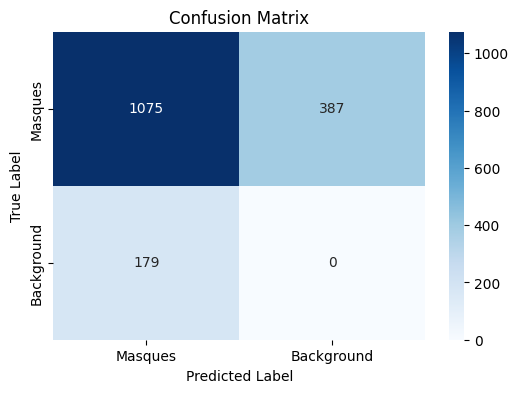

In [19]:
import pandas as pd
import seaborn as sns

cm = np.array([[total_tp, total_fn], [total_fp, 0]])

df_cm = pd.DataFrame(cm, index=["Masques", "Background"], columns=["Masques", "Background"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.savefig('confusion_matrix.png', bbox_inches='tight')

plt.show()